In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras_tuner import HyperModel, GridSearch
from utils import get_clf_report_dfs, plot_confusion_matrix, get_trials_df

In [2]:
RANDOM_SEED=42
RESULTS_DIR="./results"
MODEL_NAME="LSTM"
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

In [ ]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        
        lr = hp.Choice('learning_rate', values=[1e-4, 1e-3])
        dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.3])
        units = hp.Choice('units', values=[64, 128, 256])
        num_layers = hp.Choice('num_layers', values=[2, 3])
        
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=self.input_shape)) 
        model.add(tf.keras.layers.LSTM(
            units=units,
            return_sequences=True if num_layers > 1 else False,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
            ))
        for i in range(num_layers - 1):
            model.add(tf.keras.layers.LSTM(
                units=units,
                return_sequences=True if i < num_layers - 2 else False,
                dropout=dropout_rate,
                recurrent_dropout=dropout_rate
            ))

        model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        return model

In [5]:
tuner = GridSearch(
    LSTMHyperModel(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train))),
    objective='val_sparse_categorical_accuracy',
    seed=RANDOM_SEED,
    overwrite=True,
    directory=RESULTS_DIR,
    project_name='LSTM_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001], 'ordered': True}
dropout_rate (Choice)
{'default': 0, 'conditions': [], 'values': [0], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128], 'ordered': True}
num_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1], 'ordered': True}


In [6]:
num_epochs = 500
batch_size = 16
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
tuner.search(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)

Trial 1 Complete [00h 00m 02s]
val_sparse_categorical_accuracy: 0.19480518996715546

Best val_sparse_categorical_accuracy So Far: 0.19480518996715546
Total elapsed time: 00h 00m 02s


In [7]:
get_trials_df(tuner)

,learning_rate,dropout_rate,units,num_layers,val_loss
0,0.001000,0,128,1,0.194805


In [8]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model._name = MODEL_NAME
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,160 (274.06 KB)

 Trainable params: 70,160 (274.06 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = best_model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)
best_model.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.keras"))

Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.7462 - sparse_categorical_accuracy: 0.0704 - val_loss: 2.3406 - val_sparse_categorical_accuracy: 0.2208 - learning_rate: 0.0010
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.2006 - sparse_categorical_accuracy: 0.2201 - val_loss: 2.2269 - val_sparse_categorical_accuracy: 0.1558 - learning_rate: 0.0010
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.0849 - sparse_categorical_accuracy: 0.2663 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.3766 - learning_rate: 0.0010
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.6477 - sparse_categorical_accuracy: 0.3661 - val_loss: 1.4869 - val_sparse_categorical_accuracy: 0.4286 - learning_rate: 0.0010
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.4919 - sparse_categorical_accuracy: 0.4392 - val_loss: 1.4373 - val_sparse_categorical_accuracy: 0.4286 - learning_rate: 0.0010
Epoch 6/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/ste

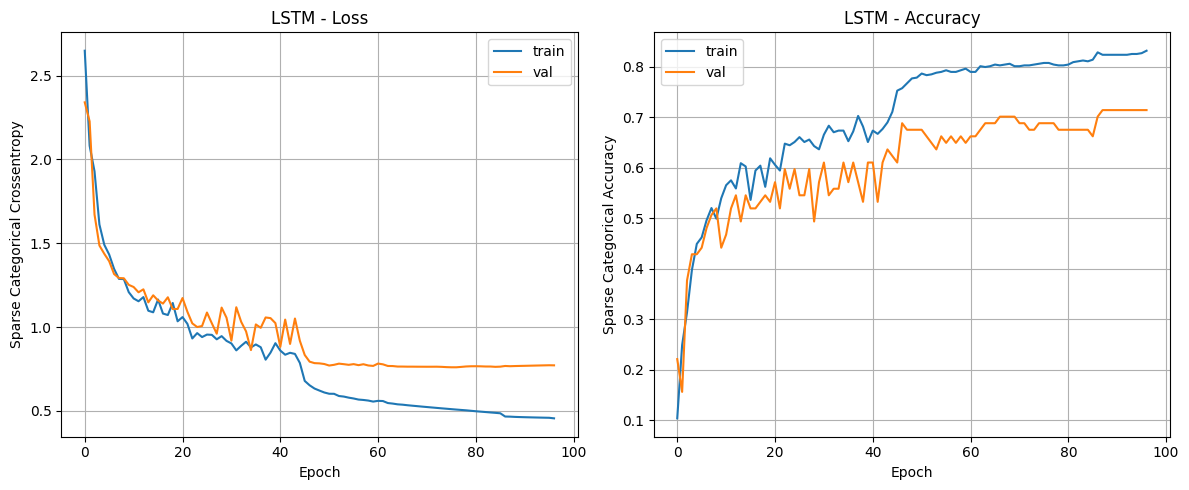

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history["loss"], label="train")
ax1.plot(history.history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Loss")
ax1.set_ylabel("Sparse Categorical Crossentropy")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(history.history["sparse_categorical_accuracy"], label="train")
ax2.plot(history.history["val_sparse_categorical_accuracy"], label="val")
ax2.set_title(f"{MODEL_NAME} - Accuracy")
ax2.set_ylabel("Sparse Categorical Accuracy")
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()

fig.tight_layout()

In [11]:
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Loss": [train_loss, test_loss],
    "Accuracy": [train_accuracy, test_accuracy]
}).set_index("Dataset")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4896 - sparse_categorical_accuracy: 0.8220
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.6957
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0476 - sparse_categorical_accuracy: 0.6910


,Loss,Accuracy
Dataset,,
Train,0.489156,0.827141
Test,0.925641,0.717949


In [12]:
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.717949,0.718998,0.718508,0.750645,0.750031,0.71875,0.717949


In [13]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.333333,0.250000,0.285714,4.000000
bigball,1.000000,0.800000,0.888889,5.000000
box,1.000000,1.000000,1.000000,5.000000
button,0.800000,0.666667,0.727273,6.000000
case,1.000000,0.800000,0.888889,5.000000
cube,0.750000,0.600000,0.666667,5.000000
cylinder,1.000000,0.600000,0.750000,5.000000
jenga,0.500000,0.600000,0.545455,5.000000
labello,0.833333,1.000000,0.909091,5.000000
lemon,0.500000,0.600000,0.545455,5.000000


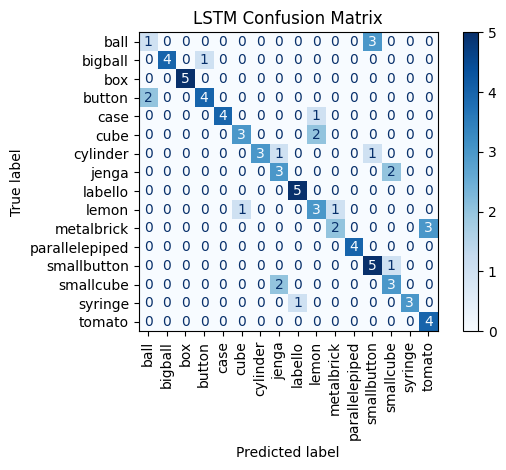

In [14]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)